
# Mario Environment Setup

## Packages Needed

Running python on 3.8 as pytorch is not compaitble with 3.8+ yet

- gym-super-mario-bros
- nes-py
- gym
- pytorch
- stable baselines

### References
- [Youtube](https://www.youtube.com/watch?v=dWmJ5CXSKdw)
- [Github](https://github.com/nicknochnack)
- [Mario Code](https://github.com/nicknochnack/MarioRL)
- [Mario Open AI Gym](https://pypi.org/project/gym-super-mario-bros/)
- [Nes-py](https://pypi.org/project/nes-py/)
- [Open AI Gym](https://gymnasium.farama.org/)
- [PyTorch](https://pytorch.org/get-started/locally/)
- [PPO Algorithm](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)
- [Stable baselines](https://stable-baselines3.readthedocs.io/en/master/guide/install.html)
- [RL Loss Introduction](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html)

In [8]:
!pip install gym_super_mario_bros nes_py

In [5]:
# Should be installed with the above packages, if not run this
!pip install gym

In [13]:
#Install pytorch before stable basline if you want to use GPU
!conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.



ResolvePackageNotFound: 
  - python=3.1



In [6]:
# Install stable baselines for RL stuff, PPO algorithm
!pip install stable-baselines3[extra]

     ---------------------------------------- 0.0/174.5 kB ? eta -:--:--
     ------- -------------------------------- 30.7/174.5 kB ? eta -:--:--
     ------------------------ ------------- 112.6/174.5 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 174.5/174.5 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
      --------------------------------------- 0.3/11.3 MB 5.2 MB/s eta 0:00:03
     - -------------------------------------- 0.5/11.3 MB 5.2 MB/s eta 0:00:03
     -- ------------------------------------- 0.7/11.3 MB 5.3 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/11.3 MB 5.1 MB/s eta 0:00:03
     ---- ----------------------------------- 1.2/11.3 MB 5.1 MB/s eta 0:00:02
     ----- ---------------------------------- 1.4/11.3 MB 5.1 MB/s eta 0:00:02
     ----- ---------------------------------- 1.7/11.3 MB 5.0 MB/s eta 0:00:02
     ------ --------------------------------- 1.9/11.3 MB 5.1 MB/s e

### Pytorch testing

In [4]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.1660, 0.9734, 0.6716],
        [0.8755, 0.1226, 0.1731],
        [0.8502, 0.3120, 0.6034],
        [0.3553, 0.3321, 0.7911],
        [0.7157, 0.6670, 0.1441]])


In [5]:
import torch
torch.cuda.is_available()

True

## Testing the environment

### Import Packages

In [84]:
# Import the game
import gym_super_mario_bros
import gym
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

### Environment setup

In [85]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
#env = JoypadSpace(env, SIMPLE_MOVEMENT)
# movement = [['NOOP'],['right'],['A','A','A'],['A','A','A','right']]
movement = [['NOOP'],['A']]
env = JoypadSpace(env, movement)

### Demo game with random movement

In [86]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(5000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

In [4]:
#Use this for python 3.9+
# Create a flag - restart or not
done = True
#Reset the environment, always reset before starting a new one
env.reset()
# Loop through each frame in the game
for step in range(5000):
    #Takes a random action from simple movements
    action = env.action_space.sample()
    #Takes a step in the game
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    #Renders the game
    env.render()
    if done:
       env.reset()
env.close()

ValueError: not enough values to unpack (expected 5, got 4)

## Preprocessing the environment

In [8]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [72]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
#env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = JoypadSpace(env, movement)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [82]:
state = env.reset()

OSError: exception: access violation reading 0x000000000003C208

In [67]:
state, reward, done, info = env.step([3])

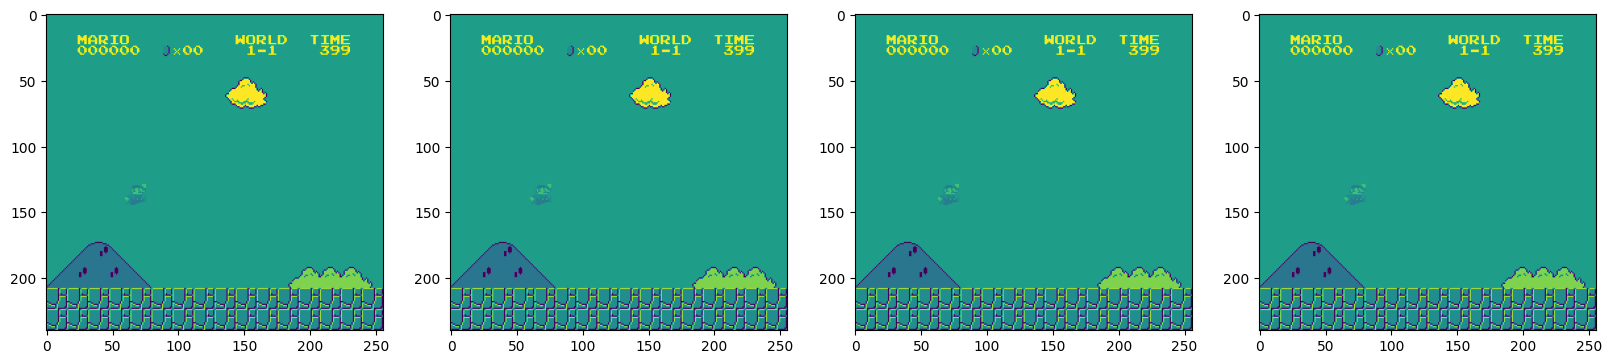

In [68]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [83]:
env.close()

ValueError: env has already been closed.

# Train RL Model

In [70]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [71]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [74]:
CHECKPOINT_DIR = './train_test/'
LOG_DIR = './logs_test/'

In [75]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [76]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [77]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs_test/PPO_1
----------------------------
| time/              |     |
|    fps             | 86  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 75            |
|    iterations           | 2             |
|    time_elapsed         | 13            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.0024873e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00293      |
|    learning_rate        | 1e-06         |
|    loss                 | 167           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000113     |
|    value_loss           | 382           |
--------------------

-------------------------------------------
| time/                   |               |
|    fps                  | 67            |
|    iterations           | 13            |
|    time_elapsed         | 98            |
|    total_timesteps      | 6656          |
| train/                  |               |
|    approx_kl            | 4.4137705e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00156      |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0682        |
|    n_updates            | 120           |
|    policy_gradient_loss | 1.99e-05      |
|    value_loss           | 0.302         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 67            |
|    iterations           | 14            |
|    time_elapsed         | 105 

------------------------------------------
| time/                   |              |
|    fps                  | 65           |
|    iterations           | 24           |
|    time_elapsed         | 187          |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 3.043993e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.0113      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.116        |
|    n_updates            | 230          |
|    policy_gradient_loss | 8.84e-05     |
|    value_loss           | 2.65         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 65           |
|    iterations           | 25           |
|    time_elapsed         | 195          |
|    total_

--------------------------------------------
| time/                   |                |
|    fps                  | 65             |
|    iterations           | 35             |
|    time_elapsed         | 274            |
|    total_timesteps      | 17920          |
| train/                  |                |
|    approx_kl            | 1.02457125e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.95          |
|    explained_variance   | -0.00802       |
|    learning_rate        | 1e-06          |
|    loss                 | 0.047          |
|    n_updates            | 340            |
|    policy_gradient_loss | -7.53e-06      |
|    value_loss           | 0.471          |
--------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 65            |
|    iterations           | 36            |
|    time_elap

------------------------------------------
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 46           |
|    time_elapsed         | 387          |
|    total_timesteps      | 23552        |
| train/                  |              |
|    approx_kl            | 7.878058e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.000644     |
|    learning_rate        | 1e-06        |
|    loss                 | 0.104        |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000117    |
|    value_loss           | 0.303        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 47           |
|    time_elapsed         | 394          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 59           |
|    iterations           | 57           |
|    time_elapsed         | 488          |
|    total_timesteps      | 29184        |
| train/                  |              |
|    approx_kl            | 8.264207e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.0286      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.0408       |
|    n_updates            | 560          |
|    policy_gradient_loss | 0.000141     |
|    value_loss           | 0.844        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 59            |
|    iterations           | 58            |
|    time_elapsed         | 497           |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 59            |
|    iterations           | 68            |
|    time_elapsed         | 582           |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | 1.3366458e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.0463        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0543        |
|    n_updates            | 670           |
|    policy_gradient_loss | 0.000109      |
|    value_loss           | 1.01          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 59            |
|    iterations           | 69            |
|    time_elapsed         | 589 

-------------------------------------------
| time/                   |               |
|    fps                  | 60            |
|    iterations           | 79            |
|    time_elapsed         | 667           |
|    total_timesteps      | 40448         |
| train/                  |               |
|    approx_kl            | 5.4194825e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00136       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0452        |
|    n_updates            | 780           |
|    policy_gradient_loss | -6.28e-05     |
|    value_loss           | 0.148         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 60            |
|    iterations           | 80            |
|    time_elapsed         | 675 

-------------------------------------------
| time/                   |               |
|    fps                  | 61            |
|    iterations           | 90            |
|    time_elapsed         | 750           |
|    total_timesteps      | 46080         |
| train/                  |               |
|    approx_kl            | 1.2587756e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00382      |
|    learning_rate        | 1e-06         |
|    loss                 | 0.04          |
|    n_updates            | 890           |
|    policy_gradient_loss | -0.000332     |
|    value_loss           | 0.102         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 61           |
|    iterations           | 91           |
|    time_elapsed         | 757     

-------------------------------------------
| time/                   |               |
|    fps                  | 61            |
|    iterations           | 101           |
|    time_elapsed         | 834           |
|    total_timesteps      | 51712         |
| train/                  |               |
|    approx_kl            | 7.6996745e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | -0.0129       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.164         |
|    n_updates            | 1000          |
|    policy_gradient_loss | 0.000919      |
|    value_loss           | 5.21          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 61            |
|    iterations           | 102           |
|    time_elapsed         | 842 

-------------------------------------------
| time/                   |               |
|    fps                  | 62            |
|    iterations           | 112           |
|    time_elapsed         | 918           |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 1.6158912e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.0164       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0395        |
|    n_updates            | 1110          |
|    policy_gradient_loss | -0.000211     |
|    value_loss           | 0.126         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 62            |
|    iterations           | 113           |
|    time_elapsed         | 925 

------------------------------------------
| time/                   |              |
|    fps                  | 62           |
|    iterations           | 123          |
|    time_elapsed         | 1002         |
|    total_timesteps      | 62976        |
| train/                  |              |
|    approx_kl            | 4.427356e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.0054       |
|    learning_rate        | 1e-06        |
|    loss                 | 0.0457       |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.000583    |
|    value_loss           | 0.163        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 62            |
|    iterations           | 124           |
|    time_elapsed         | 1010          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 63            |
|    iterations           | 134           |
|    time_elapsed         | 1087          |
|    total_timesteps      | 68608         |
| train/                  |               |
|    approx_kl            | 5.8038742e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | 0.0534        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.116         |
|    n_updates            | 1330          |
|    policy_gradient_loss | -0.000522     |
|    value_loss           | 0.437         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 135          |
|    time_elapsed         | 1095    

-------------------------------------------
| time/                   |               |
|    fps                  | 63            |
|    iterations           | 145           |
|    time_elapsed         | 1172          |
|    total_timesteps      | 74240         |
| train/                  |               |
|    approx_kl            | 0.00010819244 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.93         |
|    explained_variance   | 0.155         |
|    learning_rate        | 1e-06         |
|    loss                 | 17.3          |
|    n_updates            | 1440          |
|    policy_gradient_loss | -0.000373     |
|    value_loss           | 29.2          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 146         |
|    time_elapsed         | 1180        

------------------------------------------
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 156          |
|    time_elapsed         | 1258         |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 9.822624e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -0.0741      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.163        |
|    n_updates            | 1550         |
|    policy_gradient_loss | 0.000156     |
|    value_loss           | 1.56         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 63            |
|    iterations           | 157           |
|    time_elapsed         | 1267          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 63            |
|    iterations           | 167           |
|    time_elapsed         | 1349          |
|    total_timesteps      | 85504         |
| train/                  |               |
|    approx_kl            | 1.2797071e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | 0.2           |
|    learning_rate        | 1e-06         |
|    loss                 | 9.91          |
|    n_updates            | 1660          |
|    policy_gradient_loss | -0.000108     |
|    value_loss           | 11.5          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 168          |
|    time_elapsed         | 1357    

------------------------------------------
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 178          |
|    time_elapsed         | 1438         |
|    total_timesteps      | 91136        |
| train/                  |              |
|    approx_kl            | 0.0001790867 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.92        |
|    explained_variance   | 0.409        |
|    learning_rate        | 1e-06        |
|    loss                 | 43.5         |
|    n_updates            | 1770         |
|    policy_gradient_loss | -0.000572    |
|    value_loss           | 93.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 179          |
|    time_elapsed         | 1446         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 63            |
|    iterations           | 189           |
|    time_elapsed         | 1523          |
|    total_timesteps      | 96768         |
| train/                  |               |
|    approx_kl            | 4.0995772e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | 0.0487        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0567        |
|    n_updates            | 1880          |
|    policy_gradient_loss | -0.000504     |
|    value_loss           | 0.148         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 190          |
|    time_elapsed         | 1531    

In [ ]:
model.save('thisisatestmodel')

In [2]:
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

In [3]:
COMPLEX_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left'],
 ['left', 'A'],
 ['left', 'B'],
 ['left', 'A', 'B'],
 ['down'],
 ['up']]

In [6]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [7]:
movement = [['NOOP'],['right'],['A'],['A','B'],['left']]

In [8]:
movement

[['NOOP'], ['right'], ['A'], ['A', 'B'], ['left']]

In [11]:
type(SIMPLE_MOVEMENT)

list